In [123]:
import numpy as np
from skimage.io import imsave
from matplotlib import pyplot as plt

TOTAL_IMAGE_COUNT = 200
IMAGE_SIZE = (256, 256)

# Simple gradient

In [124]:
def generate_test_data(
    image_count,
    sizes,
):
    np.random.seed(42)  # answer to the meaning of life, should work here too
    grid = np.array(
        np.meshgrid(
            *[np.linspace(-size // 2 + 1, size // 2, size) for size in sizes],
            indexing="ij"
        )
    )

    # Create the parabolic gradient (flatfield) with and offset (darkfield)
    gradient = np.sum(grid**2, axis=0)
    gradient = 0.01 * (np.max(gradient) - gradient) + 10
    gradient_int = gradient.astype(np.int16)

    # Ground truth, for correctness checking
    truth = gradient / gradient.mean()

    # Create an image stack and add poisson noise
    images = np.random.poisson(lam=gradient_int, size=[image_count] + list(sizes))

    return gradient, images, truth


def add_blobs(images, blob_count, blob_size, blob_intensity):
    image_count, sizes = images.shape[0], images.shape[1:]
    blob_positions = np.array(
        [np.random.randint(0, size, (image_count, blob_count)) for size in sizes]
    )
    blob_positions = np.moveaxis(blob_positions, 0, -1)

    inds = np.meshgrid(*[np.arange(size) for size in sizes], indexing="ij")
    for frame, pos in enumerate(blob_positions):
        for blob in pos:
            dist = (
                inds - np.array(blob)[(slice(None), *[np.newaxis] * len(sizes))]
            ).astype(np.float64)
            gauss_image = np.exp(-np.sum(dist**2, axis=0) / (2 * blob_size**2))
            images[frame] += blob_intensity * gauss_image
    return images

In [125]:
inds = np.meshgrid(*[np.arange(size) for size in sizes], indexing="ij")

In [134]:
gradient, images, truth = generate_test_data(TOTAL_IMAGE_COUNT, IMAGE_SIZE)
images = add_blobs(images.astype(np.float64), 200, 5, 500)
images = images * np.linspace(1, 0.2, TOTAL_IMAGE_COUNT)[:, np.newaxis, np.newaxis]
# images = images + inds[0] + 100

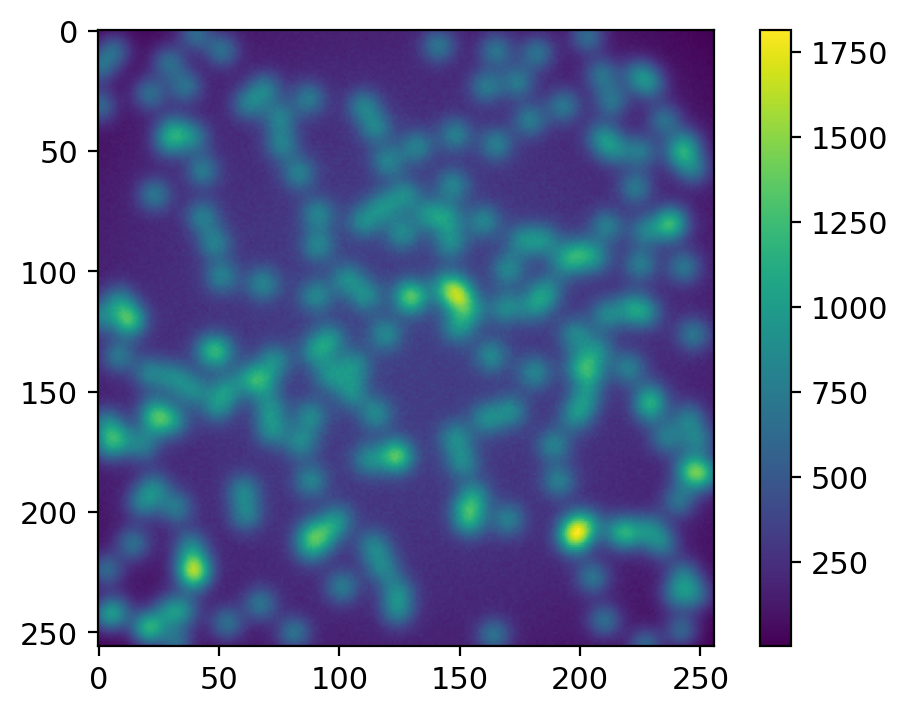

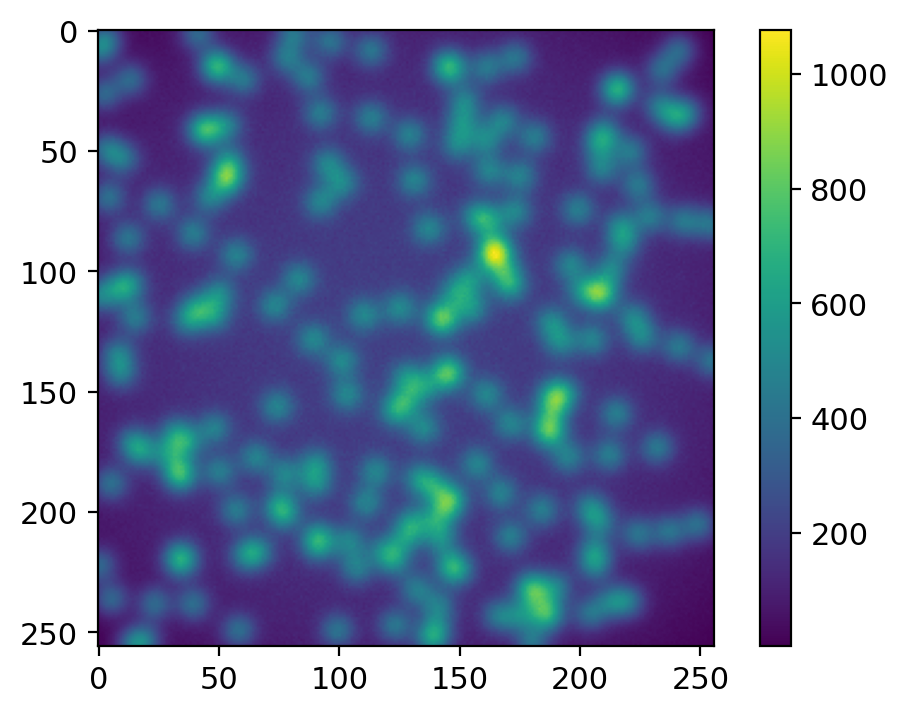

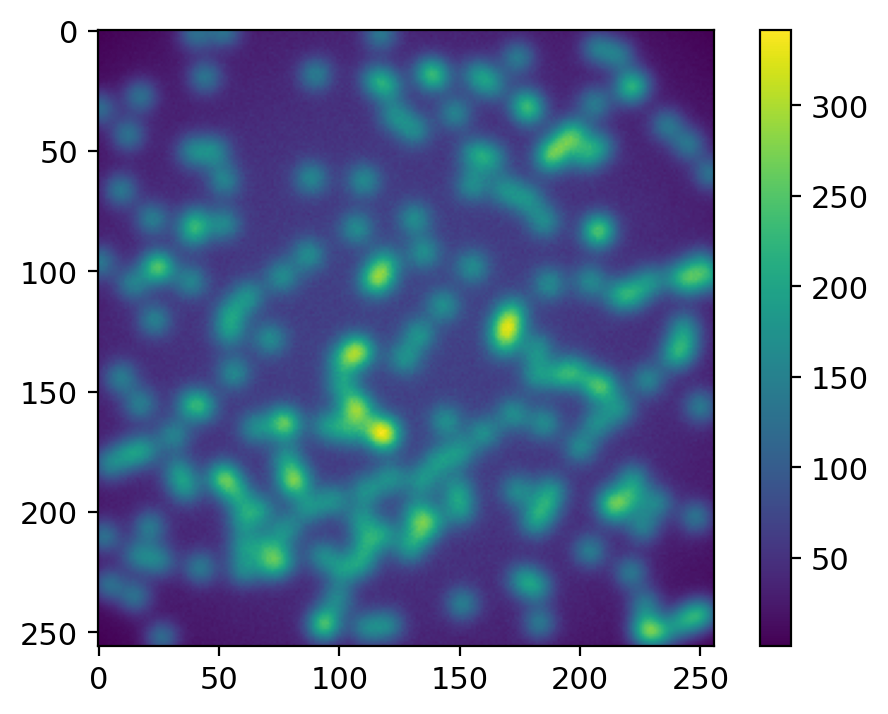

In [135]:
for i in [0, 100, 199]:
    plt.imshow(images[i])
    plt.colorbar()
    plt.show()

In [147]:
from basicpy import BaSiC

basic = BaSiC(get_darkfield=False, lambda_flatfield_coef=200)
basic.fit(images[:])

INFO:basicpy.basicpy:Initializing BaSiC 12438484544 with parameters: 
get_darkfield: False
lambda_flatfield_coef: 200

INFO:basicpy.basicpy:=== BaSiC fit started ===
INFO:basicpy.basicpy:reweighting iteration 0
INFO:basicpy.basicpy:single-step optimization score: 7.735739018244203e-07.
INFO:basicpy.basicpy:mean of S: 1.0.
INFO:basicpy.basicpy:Iteration 0 finished.
INFO:basicpy.basicpy:reweighting iteration 1
INFO:basicpy.basicpy:single-step optimization score: 7.963593589010998e-07.
INFO:basicpy.basicpy:mean of S: 0.9999998807907104.
INFO:basicpy.basicpy:Iteration 1 finished.
INFO:basicpy.basicpy:reweighting score: 0.01262219250202179
INFO:basicpy.basicpy:elapsed time: 1.6440204590035137 seconds
INFO:basicpy.basicpy:reweighting iteration 2
INFO:basicpy.basicpy:single-step optimization score: 8.393583925681014e-07.
INFO:basicpy.basicpy:mean of S: 1.0.
INFO:basicpy.basicpy:Iteration 2 finished.
INFO:basicpy.basicpy:reweighting score: 0.011676972731947899
INFO:basicpy.basicpy:elapsed time

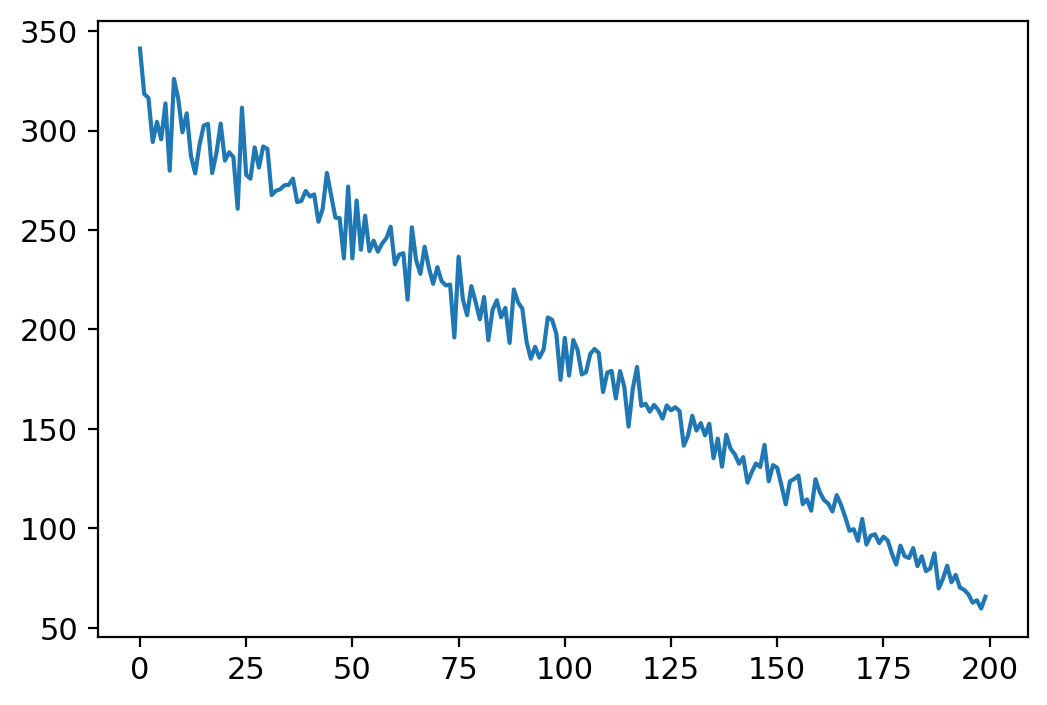

In [148]:
plt.plot(basic.baseline)

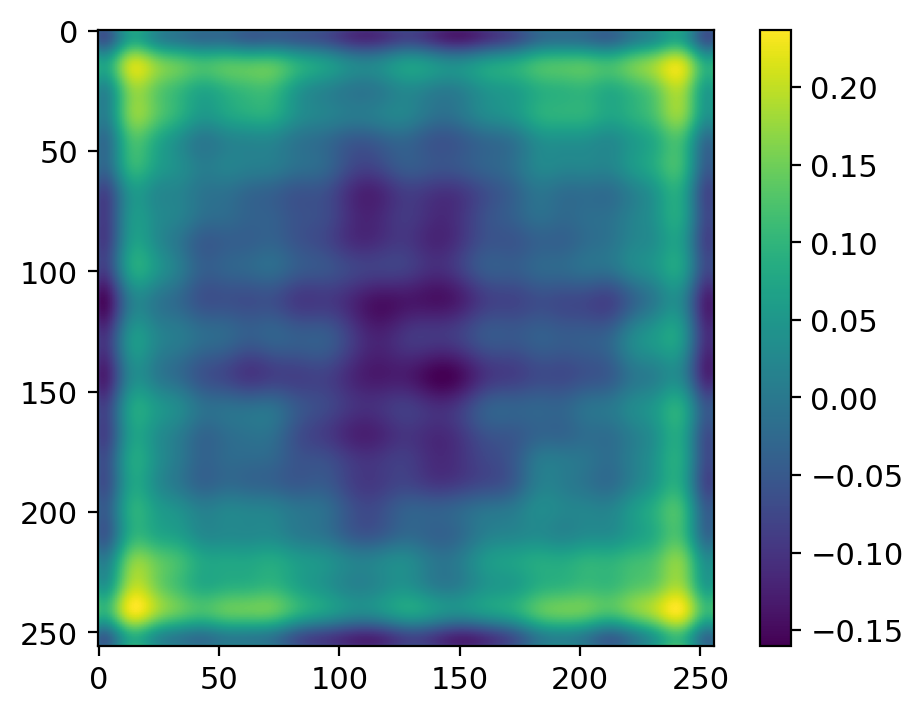

In [149]:
plt.imshow(basic.flatfield - truth)
plt.colorbar()

In [154]:
from skimage.filters import threshold_otsu

images_thresholded = np.array([im < threshold_otsu(im) for im in images])

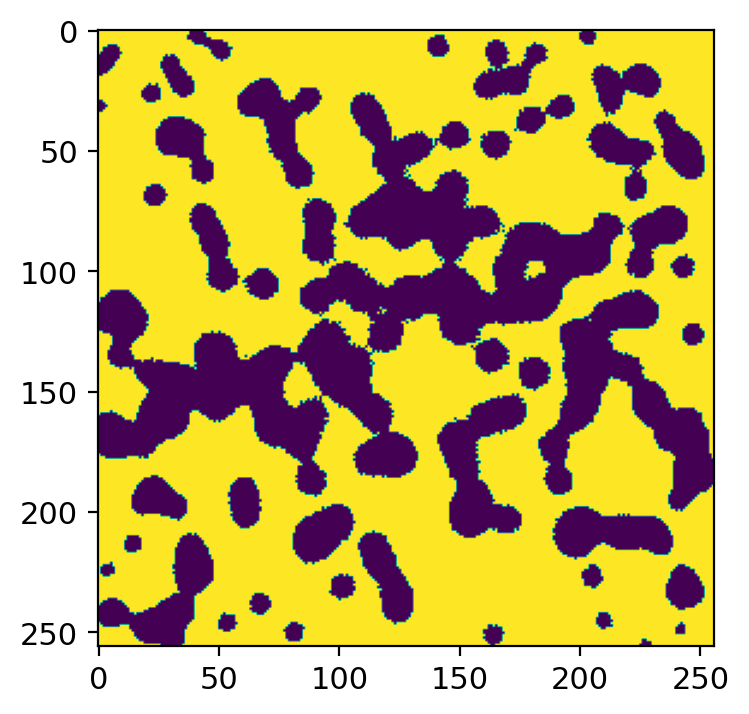

In [155]:
plt.imshow(images_thresholded[0])

In [157]:
images_thresholded.shape

(200, 256, 256)

True

In [162]:
from basicpy import BaSiC

basic = BaSiC(get_darkfield=False, lambda_flatfield_coef=200)
assert images.shape == images_thresholded.shape
basic.fit(images, fitting_weight=images_thresholded)

INFO:basicpy.basicpy:Initializing BaSiC 11252189648 with parameters: 
get_darkfield: False
lambda_flatfield_coef: 200



ValueError: fitting_weight must have the same shape as images.

# Gradient with blobs